In [6]:
import pandas as pd
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
import homework_utils

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print(tf.test.gpu_device_name())
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

Num GPUs Available:  1
/device:GPU:0


In [8]:
# Load data into pandas DataFrame
df = pd.read_parquet("dataset/unscaled_train_data.parquet")

# Define the feature and target columns
feature_cols = df.columns[:-1]
target_col = df.columns[-1]
O = len(df[target_col].unique())
I = len(feature_cols)


# Define a function to create the Keras model
def create_model(hidden_size: int, lr: float = None, m: float = None):
    model = Sequential()
    model.add(Dense(hidden_size, input_dim=len(feature_cols), activation="sigmoid"))
    model.add(Dense(O, activation="softmax"))
    if lr and m:
        optimizer = SGD(learning_rate=lr, momentum=m)
    else:
        optimizer = Adam(learning_rate=0.01)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["categorical_crossentropy", "mean_squared_error", "accuracy"],
    )
    return model


# Create a 5-fold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
from importlib import reload

reload(homework_utils)
scores = []
hidden_layer_matrice = [
    {
        "hidden_size": O,
    },
    {
        "hidden_size": int((I + O) / 2),
    },
    {
        "hidden_size": I + O,
    },
]

reload(homework_utils)
import logging

logging.getLogger().setLevel(logging.INFO)

hiddensize_test_resuts = homework_utils.wrap_test_case(
    hidden_layer_matrice, create_model, df[feature_cols].values, df[target_col].values
)

INFO:root:Running testcase {'hidden_size': 15}
INFO:root:Running testcase {'hidden_size': 17}
INFO:root:Running testcase {'hidden_size': 20}


In [10]:
for result in hiddensize_test_resuts:
    print(result.testcase)
    homework_utils.print_scores(homework_utils.score_from_histories(result.histories))
    print("=" * 30)

{'hidden_size': 15}
Validation Cross Entropy: 0.0685 (+/- 0.0038)
Validation MSE: 0.0063 (+/- 0.0004)
Validation Accuracy: 0.9798 (+/- 0.0015)
{'hidden_size': 17}
Validation Cross Entropy: 0.0602 (+/- 0.0031)
Validation MSE: 0.0054 (+/- 0.0002)
Validation Accuracy: 0.9829 (+/- 0.0009)
{'hidden_size': 20}
Validation Cross Entropy: 0.0541 (+/- 0.0027)
Validation MSE: 0.0049 (+/- 0.0003)
Validation Accuracy: 0.9846 (+/- 0.0012)


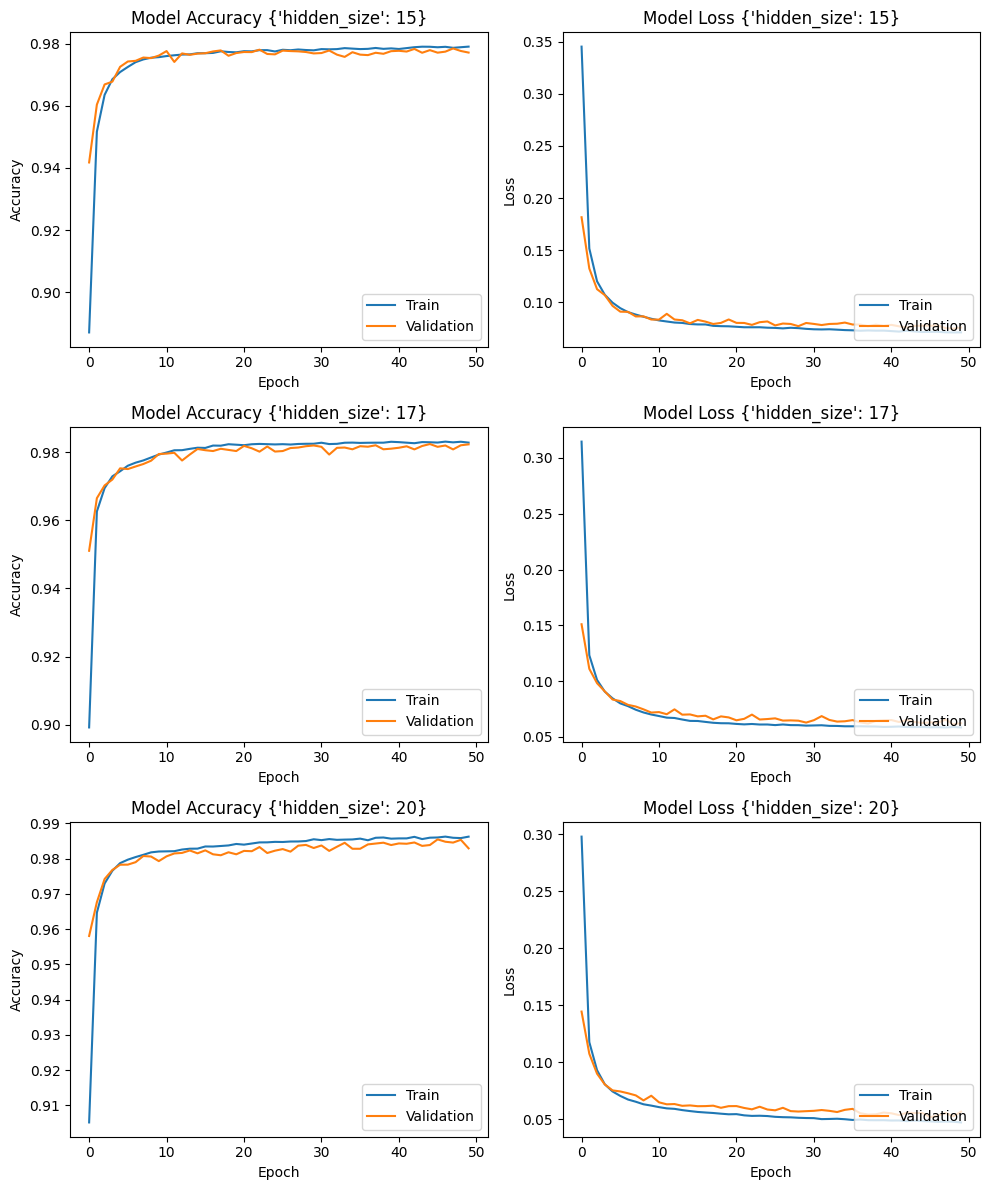

In [11]:
reload(homework_utils)

# set up the figure
homework_utils.figure_from_histories(
    [I.histories[0] for I in hiddensize_test_resuts],
    [I.testcase for I in hiddensize_test_resuts],
)

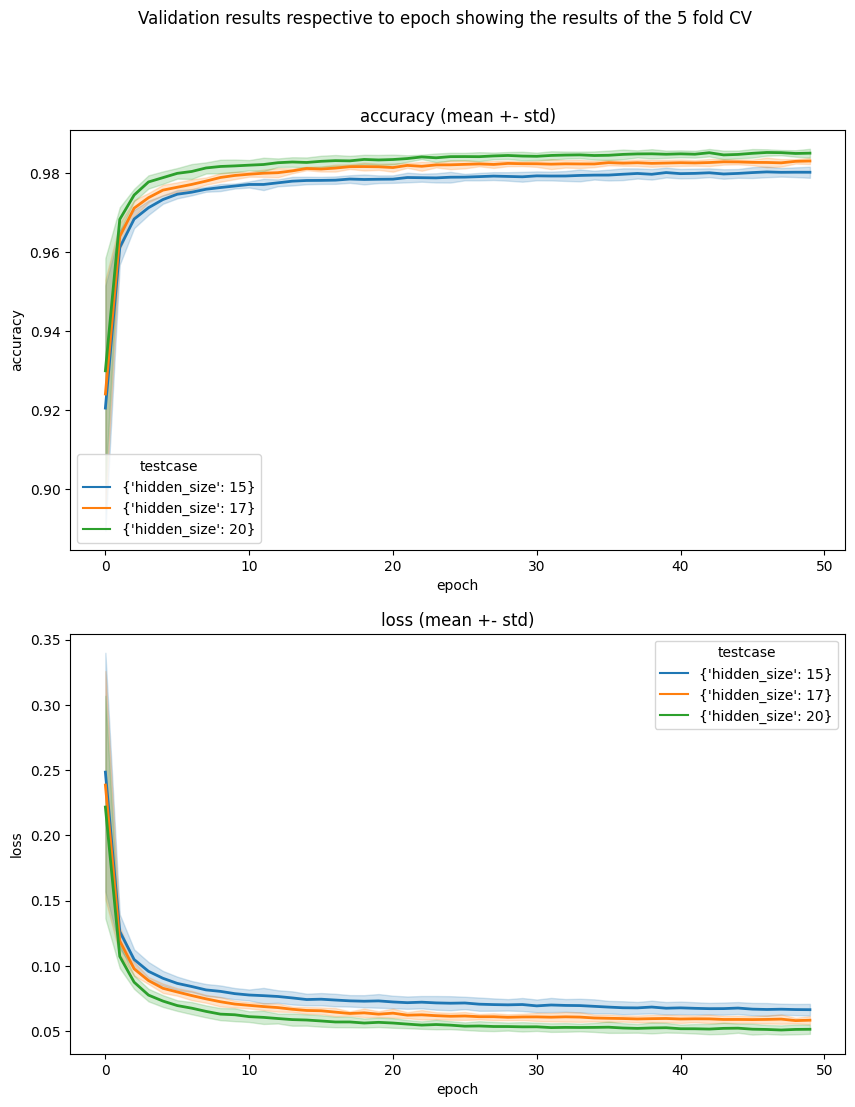

In [63]:
homework_utils.visualisation_with_confidence(
    hiddensize_test_resuts, validation_only=True
)

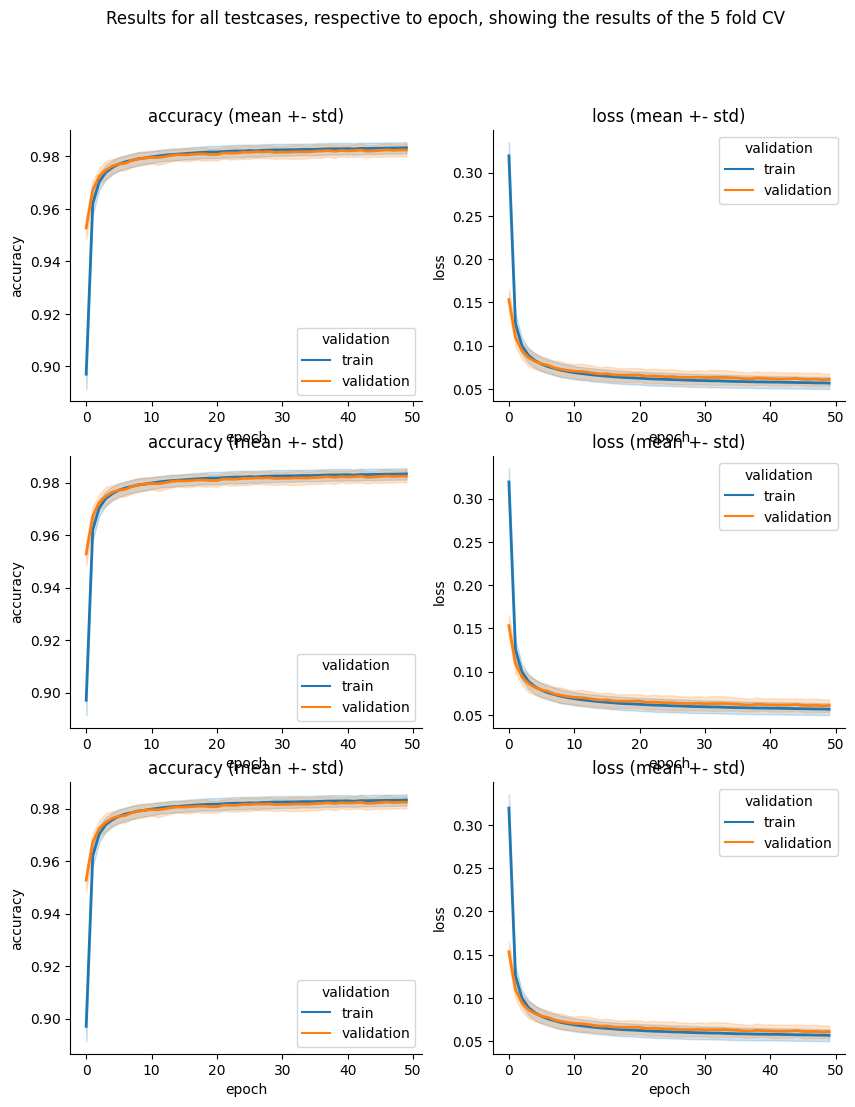

In [64]:
homework_utils.visualisation_with_confidence(
    hiddensize_test_resuts, validation_only=False
)

In [12]:
lr_m_matrice = [
    {"hidden_size": I + O, "lr": 0.001, "m": 0.2},
    {"hidden_size": I + O, "lr": 0.001, "m": 0.6},
    {"hidden_size": I + O, "lr": 0.05, "m": 0.6},
    {"hidden_size": I + O, "lr": 0.1, "m": 0.6},
]

lr_m_test_results = homework_utils.wrap_test_case(
    lr_m_matrice, create_model, df[feature_cols].values, df[target_col].values
)

INFO:root:Running testcase {'hidden_size': 20, 'lr': 0.001, 'm': 0.2}
INFO:root:Running testcase {'hidden_size': 20, 'lr': 0.001, 'm': 0.6}
INFO:root:Running testcase {'hidden_size': 20, 'lr': 0.05, 'm': 0.6}
INFO:root:Running testcase {'hidden_size': 20, 'lr': 0.1, 'm': 0.6}


In [13]:
for result in lr_m_test_results:
    print(result.testcase)
    homework_utils.print_scores(homework_utils.score_from_histories(result.histories))
    print("=" * 30)

{'hidden_size': 20, 'lr': 0.001, 'm': 0.2}
Validation Cross Entropy: 0.5939 (+/- 0.0074)
Validation MSE: 0.0608 (+/- 0.0007)
Validation Accuracy: 0.7988 (+/- 0.0036)
{'hidden_size': 20, 'lr': 0.001, 'm': 0.6}
Validation Cross Entropy: 0.4793 (+/- 0.0124)
Validation MSE: 0.0493 (+/- 0.0015)
Validation Accuracy: 0.8325 (+/- 0.0074)
{'hidden_size': 20, 'lr': 0.05, 'm': 0.6}
Validation Cross Entropy: 0.0739 (+/- 0.0022)
Validation MSE: 0.0069 (+/- 0.0001)
Validation Accuracy: 0.9784 (+/- 0.0003)
{'hidden_size': 20, 'lr': 0.1, 'm': 0.6}
Validation Cross Entropy: 0.0634 (+/- 0.0031)
Validation MSE: 0.0058 (+/- 0.0003)
Validation Accuracy: 0.9819 (+/- 0.0010)


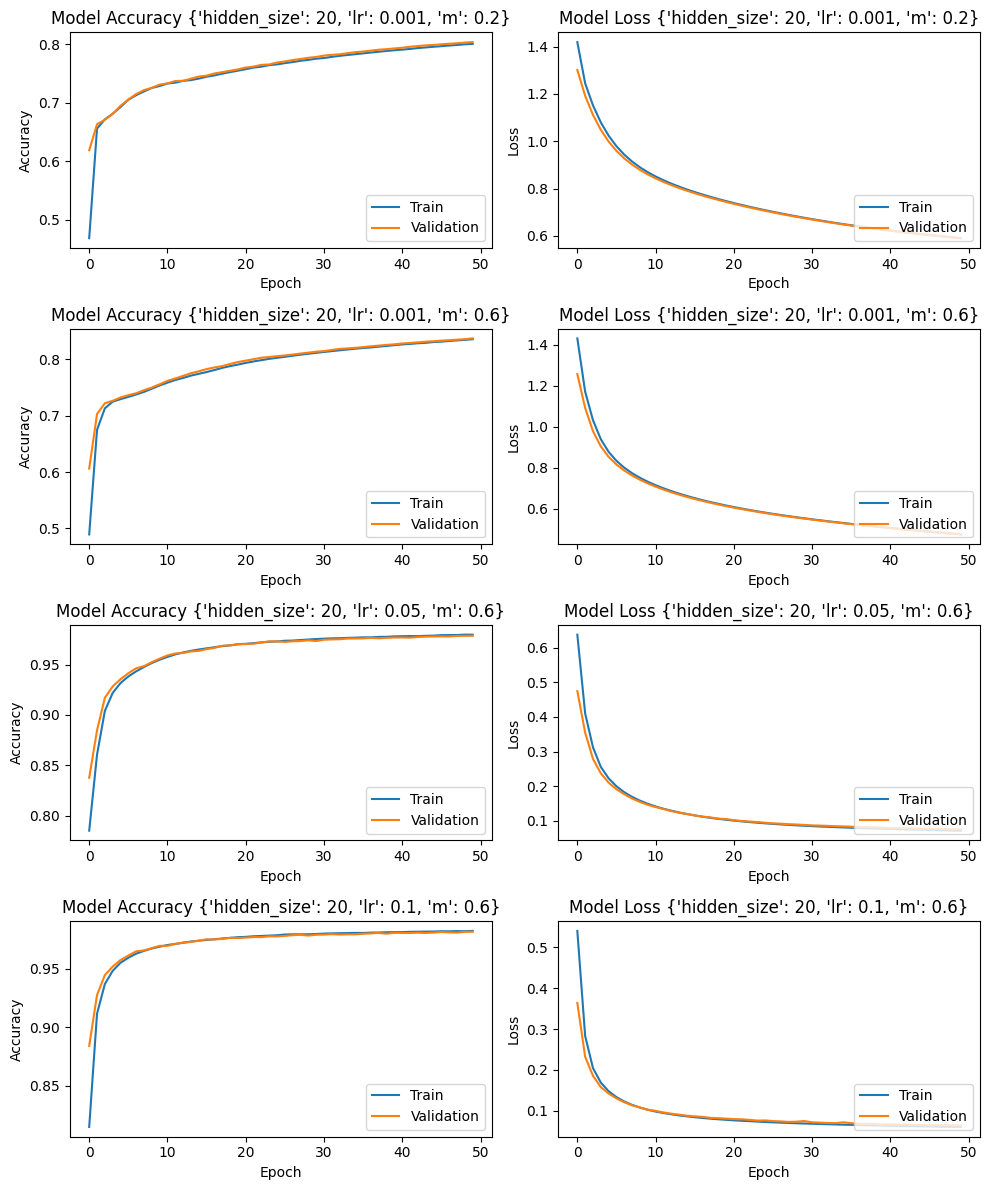

In [14]:
# set up the figure
homework_utils.figure_from_histories(
    [I.histories[0] for I in lr_m_test_results], [I.testcase for I in lr_m_test_results]
)

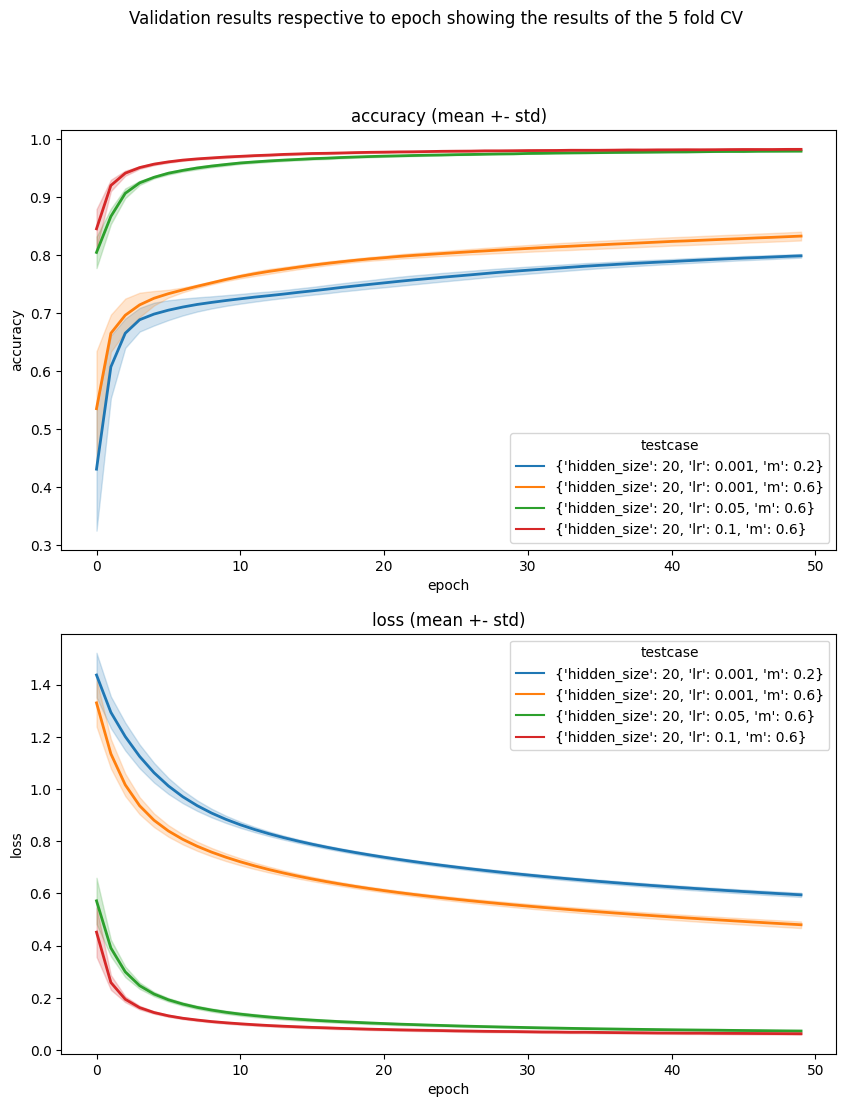

In [65]:
homework_utils.visualisation_with_confidence(lr_m_test_results, validation_only=True)

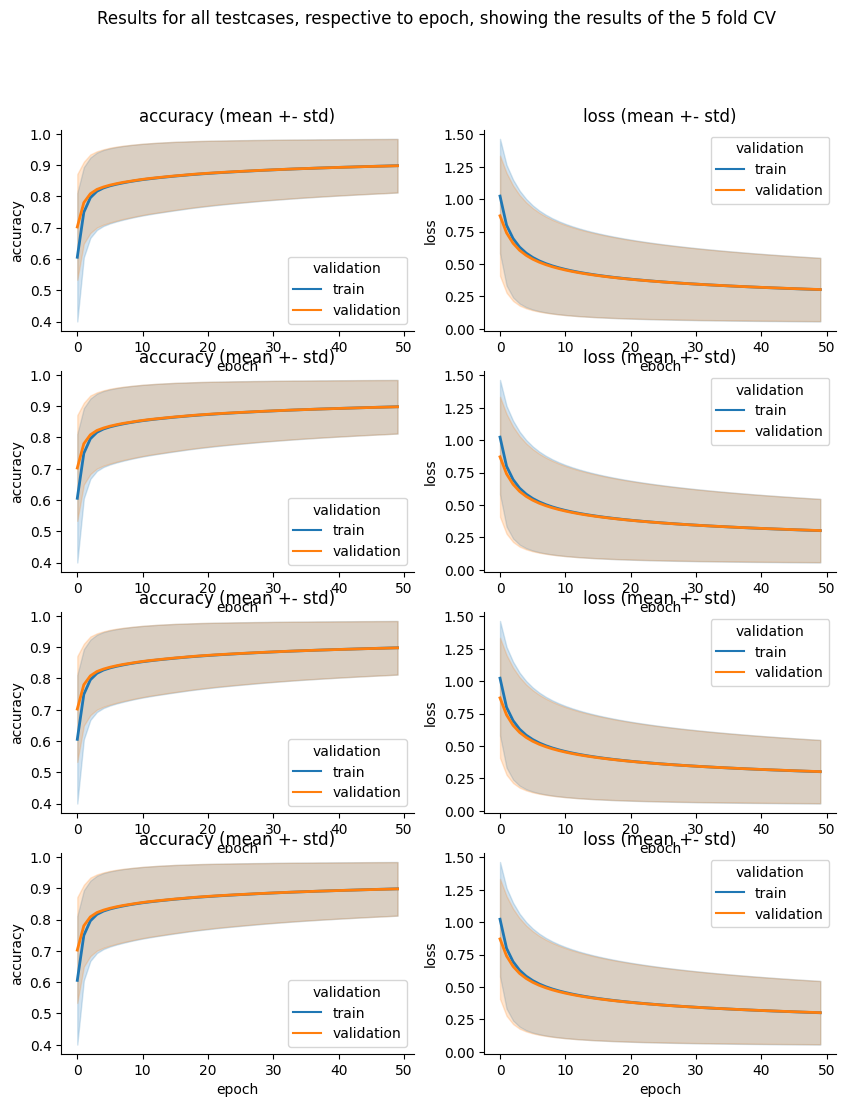

In [66]:
homework_utils.visualisation_with_confidence(lr_m_test_results, validation_only=False)

In [16]:
from keras import regularizers


def create_normalised_model(coef):
    model = Sequential()
    model.add(
        Dense(
            I + O,
            input_dim=len(feature_cols),
            activation="sigmoid",
            bias_regularizer=regularizers.L2(coef),
        )
    )
    model.add(Dense(O, activation="softmax"))
    optimizer = Adam(learning_rate=0.01)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["categorical_crossentropy", "mean_squared_error", "accuracy"],
    )
    return model

In [17]:
test_matrice_reg = [
    {"coef": 0.1},
    {"coef": 0.5},
    {"coef": 0.9},
]

regularization_test_results = homework_utils.wrap_test_case(
    test_matrice_reg,
    create_normalised_model,
    df[feature_cols].values,
    df[target_col].values,
)

INFO:root:Running testcase {'coef': 0.1}
INFO:root:Running testcase {'coef': 0.5}
INFO:root:Running testcase {'coef': 0.9}


In [18]:
for result in regularization_test_results:
    print(result.testcase)
    homework_utils.print_scores(homework_utils.score_from_histories(result.histories))
    print("=" * 30)

{'coef': 0.1}
Validation Cross Entropy: 0.0615 (+/- 0.0038)
Validation MSE: 0.0056 (+/- 0.0004)
Validation Accuracy: 0.9822 (+/- 0.0014)
{'coef': 0.5}
Validation Cross Entropy: 0.0606 (+/- 0.0020)
Validation MSE: 0.0055 (+/- 0.0002)
Validation Accuracy: 0.9827 (+/- 0.0008)
{'coef': 0.9}
Validation Cross Entropy: 0.0617 (+/- 0.0003)
Validation MSE: 0.0057 (+/- 0.0001)
Validation Accuracy: 0.9817 (+/- 0.0005)


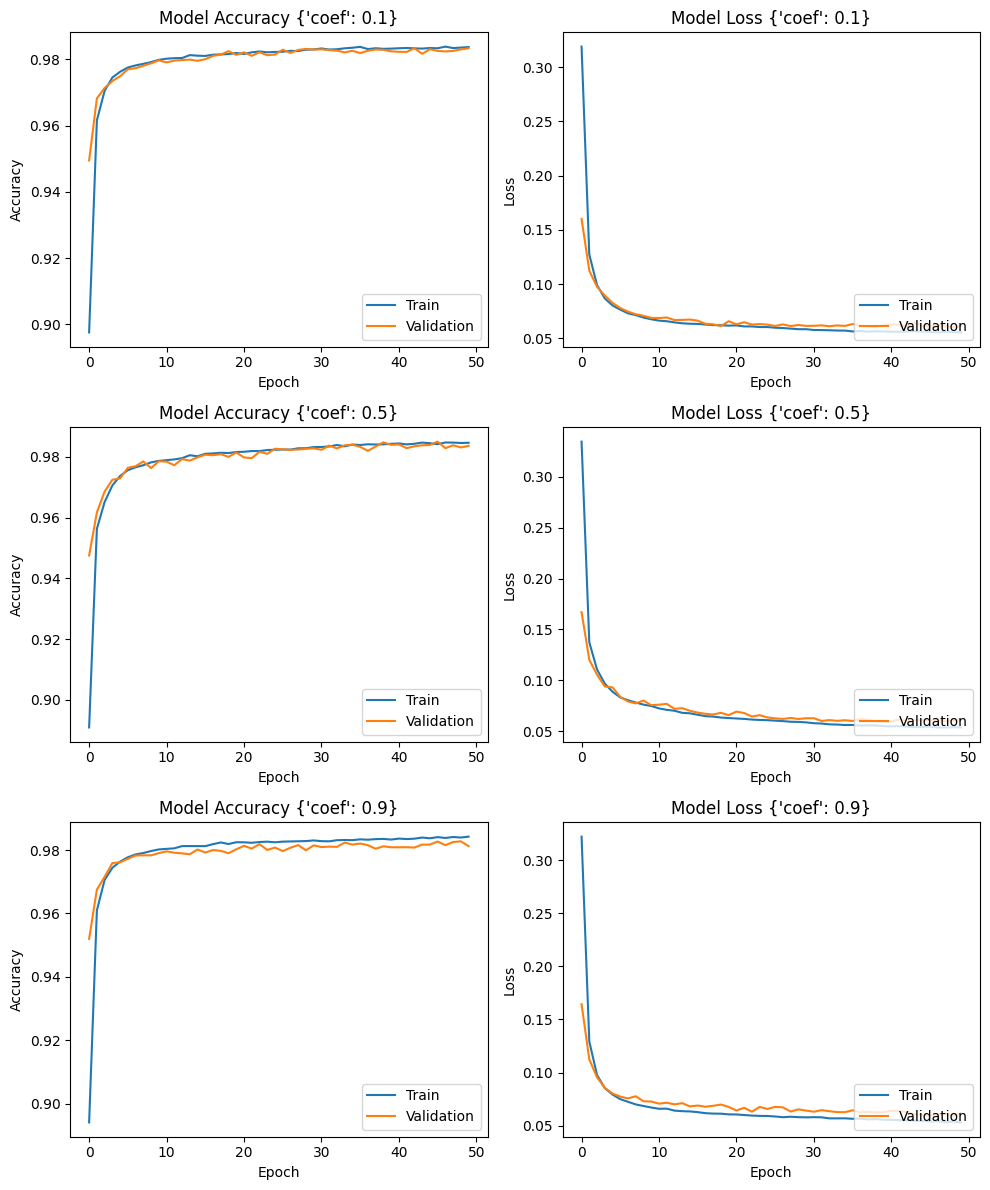

In [19]:
homework_utils.figure_from_histories(
    [I.histories[0] for I in regularization_test_results],
    [I.testcase for I in regularization_test_results],
)

Index(['epoch', 'run', 'testcase', 'validation', 'accuracy',
       'categorical_crossentropy', 'loss', 'mean_squared_error'],
      dtype='object', name='variable')


<Figure size 1000x600 with 0 Axes>

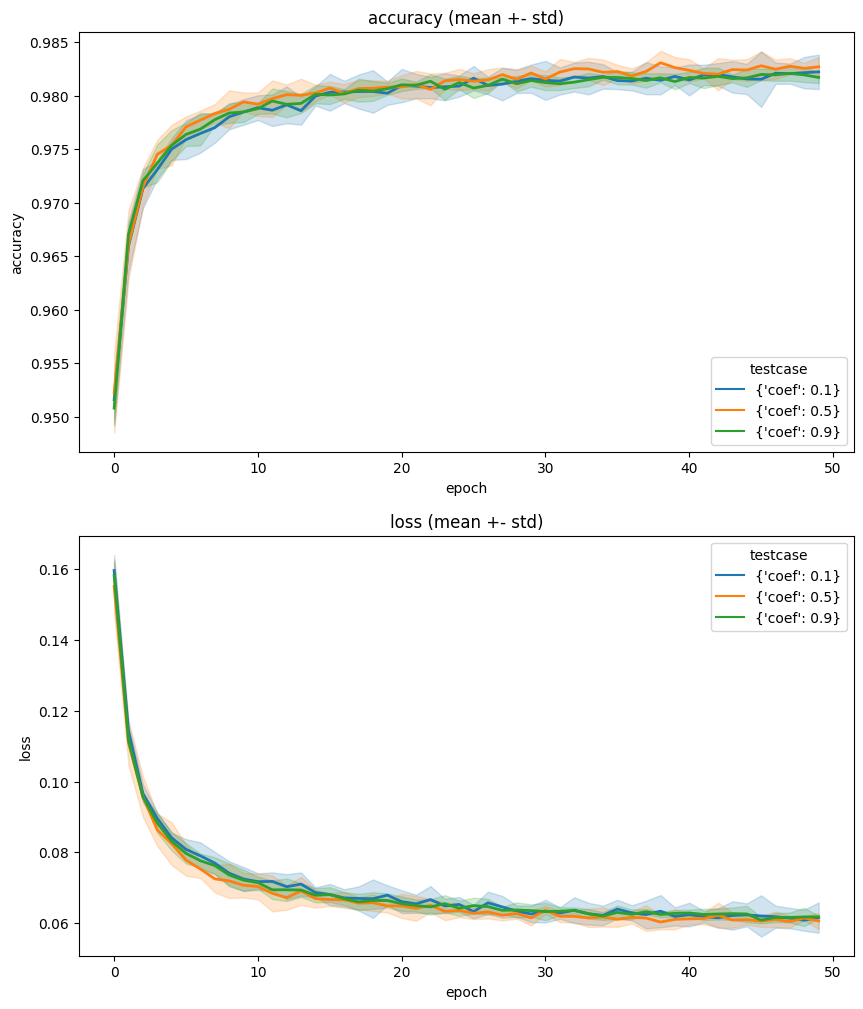

In [53]:
homework_utils.visualisation_with_confidence(
    regularization_test_results, validation_only=True
)

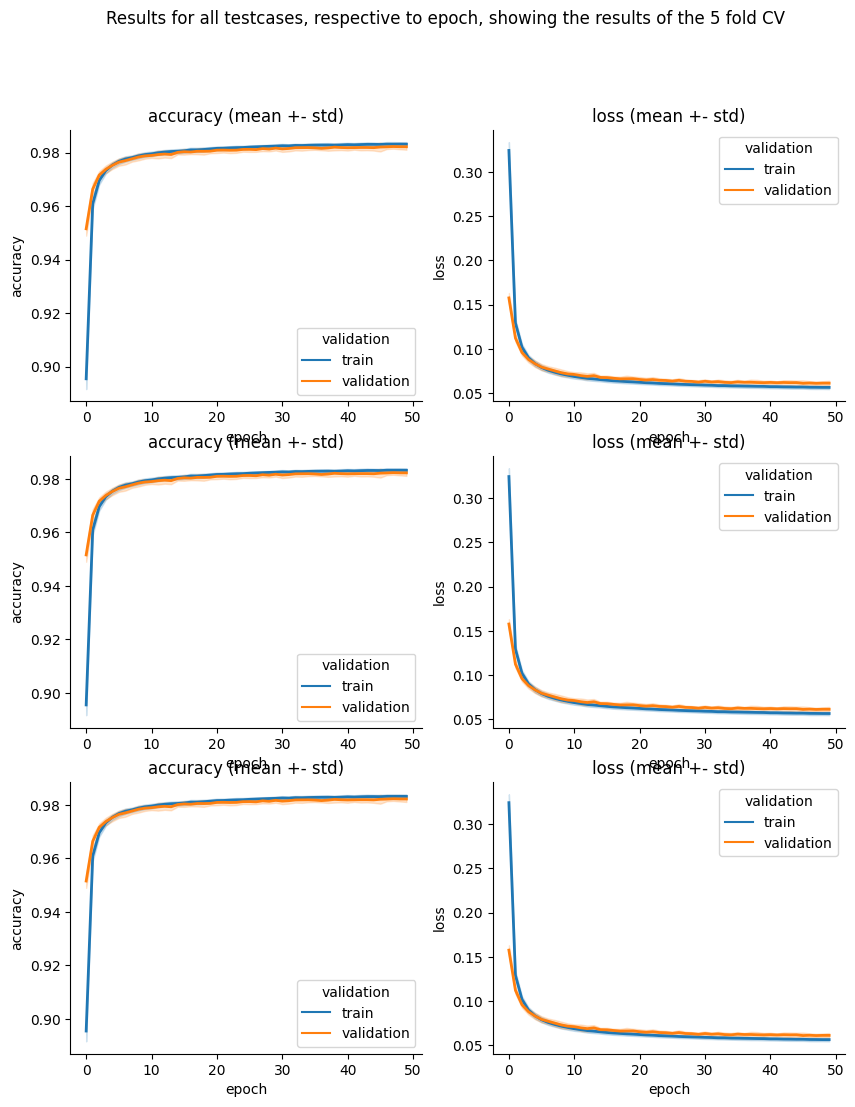

In [62]:
homework_utils.visualisation_with_confidence(
    regularization_test_results, validation_only=False
)